In [22]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.losses import BinaryCrossentropy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score, ConfusionMatrixDisplay

from typing import List

In [2]:
df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')

df_concat = df1._append(df2, ignore_index=True)
df_concat = df_concat.iloc[:, 2:]
df_concat.head(5)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [3]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Inflight wifi service              129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Ease of Online booking             129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Food and drink                     129880 non-null  int64  
 11  Online boarding                    1298

In [4]:
df_concat.isnull().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction                           0
dtype: int64

In [5]:
df_concat.fillna({'Arrival Delay in Minutes': 0}, inplace=True)

In [6]:
def replaceCategorial(df: pd.DataFrame, columns: List[str], mapping: dict) -> None:
  for column in columns:
    df[column] = df[column].map(mapping)

In [7]:
replaceCategorial(df_concat, ['Gender'], {'Male': 0, 'Female': 1})
replaceCategorial(df_concat, ['Customer Type'], {'disloyal Customer': 0, 'Loyal Customer': 1})
replaceCategorial(df_concat, ['Type of Travel'], {'Personal Travel': 0, 'Business travel': 1})
replaceCategorial(df_concat, ['Class'], {'Eco': 0, 'Eco Plus': 1, 'Business': 2})
replaceCategorial(df_concat, ['satisfaction'], {'neutral or dissatisfied': 0, 'satisfied': 1})

df_concat.head(5)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,1,13,0,1,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,0,0,25,1,2,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,1,1,26,1,2,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,1,1,25,1,2,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,0,1,61,1,2,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [11]:
X = df_concat.drop('satisfaction', axis=1)
y = df_concat['satisfaction']

# Normalization
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(
  f"Train: {X_train.shape}, {y_train.shape}\n"
  f"Val: {X_val.shape}, {y_val.shape}\n"
  f"Test: {X_test.shape}, {y_test.shape}"
)

Train: (83123, 22), (83123,)
Val: (20781, 22), (20781,)
Test: (25976, 22), (25976,)


In [13]:
model = Sequential([
  Dense(X_train.shape[1], activation='sigmoid'),
  BatchNormalization(),
  Dense(32, activation='relu'),
  Dropout(.2),
  BatchNormalization(),
  Dense(16, activation='sigmoid'),
  Dropout(.5),
  BatchNormalization(),
  Dense(32, activation='relu'),
  BatchNormalization(),
  Dense(16, activation='sigmoid'),
  Dropout(.2),
  BatchNormalization(),
  Dense(1, activation='sigmoid')
])

callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

model.compile(optimizer=Adam(learning_rate=0.01), loss=BinaryCrossentropy(), metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=256, validation_data=(X_val, y_val), epochs=150, callbacks=[callback])

Epoch 1/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8390 - loss: 0.3731 - val_accuracy: 0.6919 - val_loss: 0.5149
Epoch 2/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9246 - loss: 0.1832 - val_accuracy: 0.9174 - val_loss: 0.1897
Epoch 3/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9289 - loss: 0.1692 - val_accuracy: 0.9215 - val_loss: 0.2247
Epoch 4/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9343 - loss: 0.1588 - val_accuracy: 0.9397 - val_loss: 0.2071
Epoch 5/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9359 - loss: 0.1543 - val_accuracy: 0.9332 - val_loss: 0.2118
Epoch 6/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9377 - loss: 0.1545 - val_accuracy: 0.9446 - val_loss: 0.2126
Epoch 7/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9405 - loss: 0.1461 - val_accuracy: 0.9466 - val_loss: 0.1743
Epoch 8/150
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9396 - loss: 0.1469 - val_accu

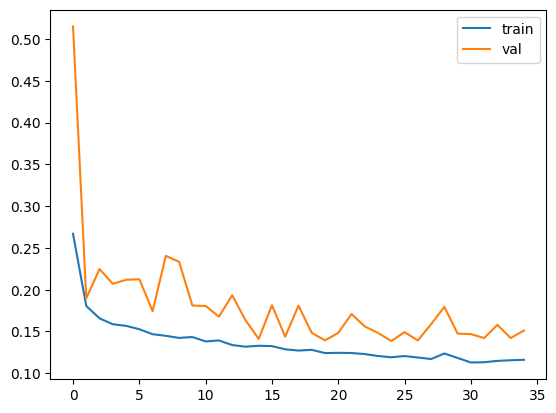

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

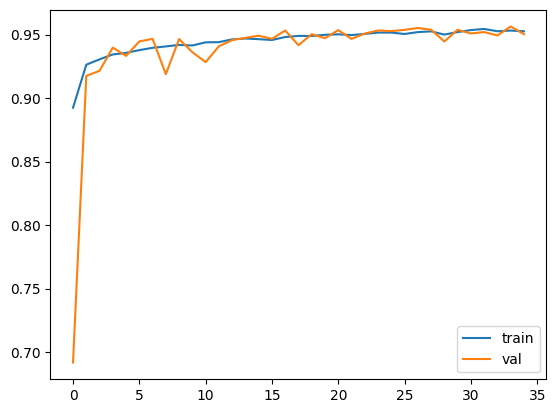

In [15]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')

plt.legend()
plt.show()

In [17]:
model.evaluate(X_test, y_test)

812/812 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.9523 - loss: 0.1370


[0.13706417381763458, 0.9526870846748352]

In [20]:
score_dict={}
pred=(model.predict((X_test, y_test)) > 0.5).astype(int)

print(classification_report(pred, y_test))


score_dict['model']={
  'roc_auc_score':roc_auc_score(y_test.values,pred),
  'f1_score':f1_score(y_test.values,pred),
  'accuracy_score':accuracy_score(y_test.values,pred)
}

812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     14649
           1       0.94      0.95      0.95     11327

    accuracy                           0.95     25976
   macro avg       0.95      0.95      0.95     25976
weighted avg       0.95      0.95      0.95     25976



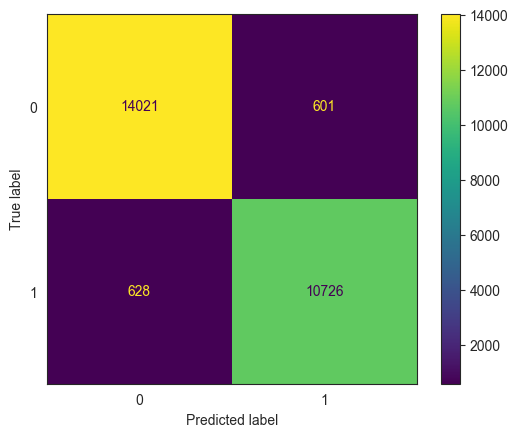

In [23]:
sns.set_style('white')

ConfusionMatrixDisplay.from_predictions(y_test.values, pred)